# Environment & Libraries Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from mlxtend.classifier import StackingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, average_precision_score
from google.colab import drive
from imblearn.pipeline import Pipeline
from collections import Counter
import joblib
import gradio as gr

## Mounting Google Drive


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Loading and Preprocesing

In [ ]:
# Load datasets from specified CSV files
df1 = pd.read_csv('/content/drive/MyDrive/Magisterka/Dataset/l1-nondoh.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Magisterka/Dataset/l2-benign.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Magisterka/Dataset/l2-malicious.csv')

# Align columns before concatenation
common_cols = list(set(df1.columns) & set(df2.columns) & set(df3.columns))
df1 = df1[common_cols]
df2 = df2[common_cols]
df3 = df3[common_cols]

# Concatenate the dataframes into a single dataframe
df = pd.concat([df1, df2, df3], ignore_index=True)

print(df.info)

# Remove duplicate rows and reset index
df = df.drop_duplicates().reset_index(drop=True)

# Shuffle the combined dataframe randomly
shuffled_df = df.sample(frac=1, random_state=42)
df = shuffled_df.reset_index(drop=True)

# Drop high-cardinality or identifier columns that are not useful for modeling
drop_cols = ['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Handle missing values by dropping rows with any missing values
df = df.dropna(axis=0)

# Separate features (X) and the target label (y)
X = df.drop('Label', axis=1)
y = df['Label']

<bound method DataFrame.info of          FlowReceivedRate  ResponseTimeTimeVariance  ResponseTimeTimeMode  \
0            35062.191354              1.107852e-07              0.000014   
1             1460.768585              3.224052e+00              0.000900   
2             4085.741355              0.000000e+00              0.033683   
3             1976.186947              0.000000e+00              0.060687   
4             3376.822717              0.000000e+00              0.019545   
...                   ...                       ...                   ...   
1167131        381.861040              8.716113e-09              0.000028   
1167132        381.440553              8.737216e-07              0.000024   
1167133        382.259718              1.558392e-06              0.000025   
1167134        381.385105              1.055948e-09              0.000017   
1167135        448.571115              3.638538e-08              0.000021   

         FlowBytesSent  PacketLengthCoeffic

In [ ]:
# Create a copy of the dataframe to include the 'Label' column
df_02 = df.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# Encode the 'Label' column into numerical representations
df_02['Label'] = le.fit_transform(df_02['Label'])

# Display the dataframe with the encoded labels
print(df_02.head()) # Using head() to avoid printing the entire large dataframe

In [ ]:
# Assign the 'Label' column of the encoded dataframe to the target variable y
y = df_02['Label']

# Display the target variable
y

,Label
0,2
1,0
2,1
3,1
4,1
...,...
1167131,2
1167132,2
1167133,2
1167134,2


In [ ]:
# Print the mapping of original labels to their encoded numerical representations
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'Benign': np.int64(0), 'Malicious': np.int64(1), 'NonDoH': np.int64(2)}


# Data Analysis

## Dataset Overview

<class 'pandas.core.frame.DataFrame'>
Index: 1159108 entries, 0 to 1167135
Data columns (total 30 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   Duration                                1159108 non-null  float64
 1   ResponseTimeTimeMedian                  1159108 non-null  float64
 2   FlowBytesReceived                       1159108 non-null  int64  
 3   PacketLengthSkewFromMedian              1159108 non-null  float64
 4   FlowBytesSent                           1159108 non-null  int64  
 5   ResponseTimeTimeStandardDeviation       1159108 non-null  float64
 6   PacketTimeMode                          1159108 non-null  float64
 7   PacketLengthMode                        1159108 non-null  int64  
 8   ResponseTimeTimeSkewFromMedian          1159108 non-null  float64
 9   PacketTimeSkewFromMode                  1159108 non-null  float64
 10  PacketTimeCoefficientofVariation   

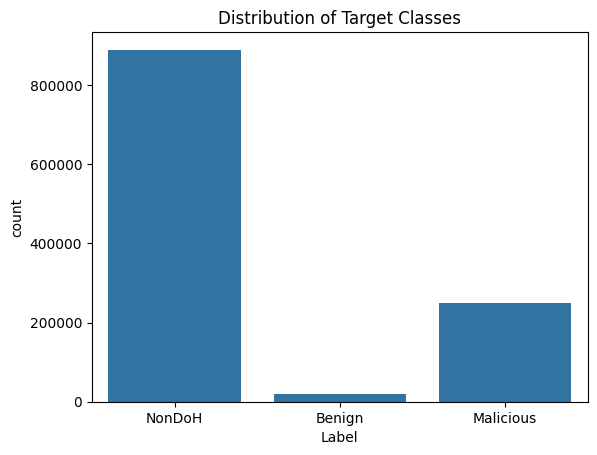

In [ ]:
# General info about the dataframe (data types, non-null values, memory usage)
print(df.info())

# Descriptive statistics for numerical columns
print(df.describe())

# Visualize the distribution of the target classes to check for imbalance
sns.countplot(data=df, x='Label')
plt.title('Distribution of Target Classes')
plt.show()

## Feature Analysis & Correlation



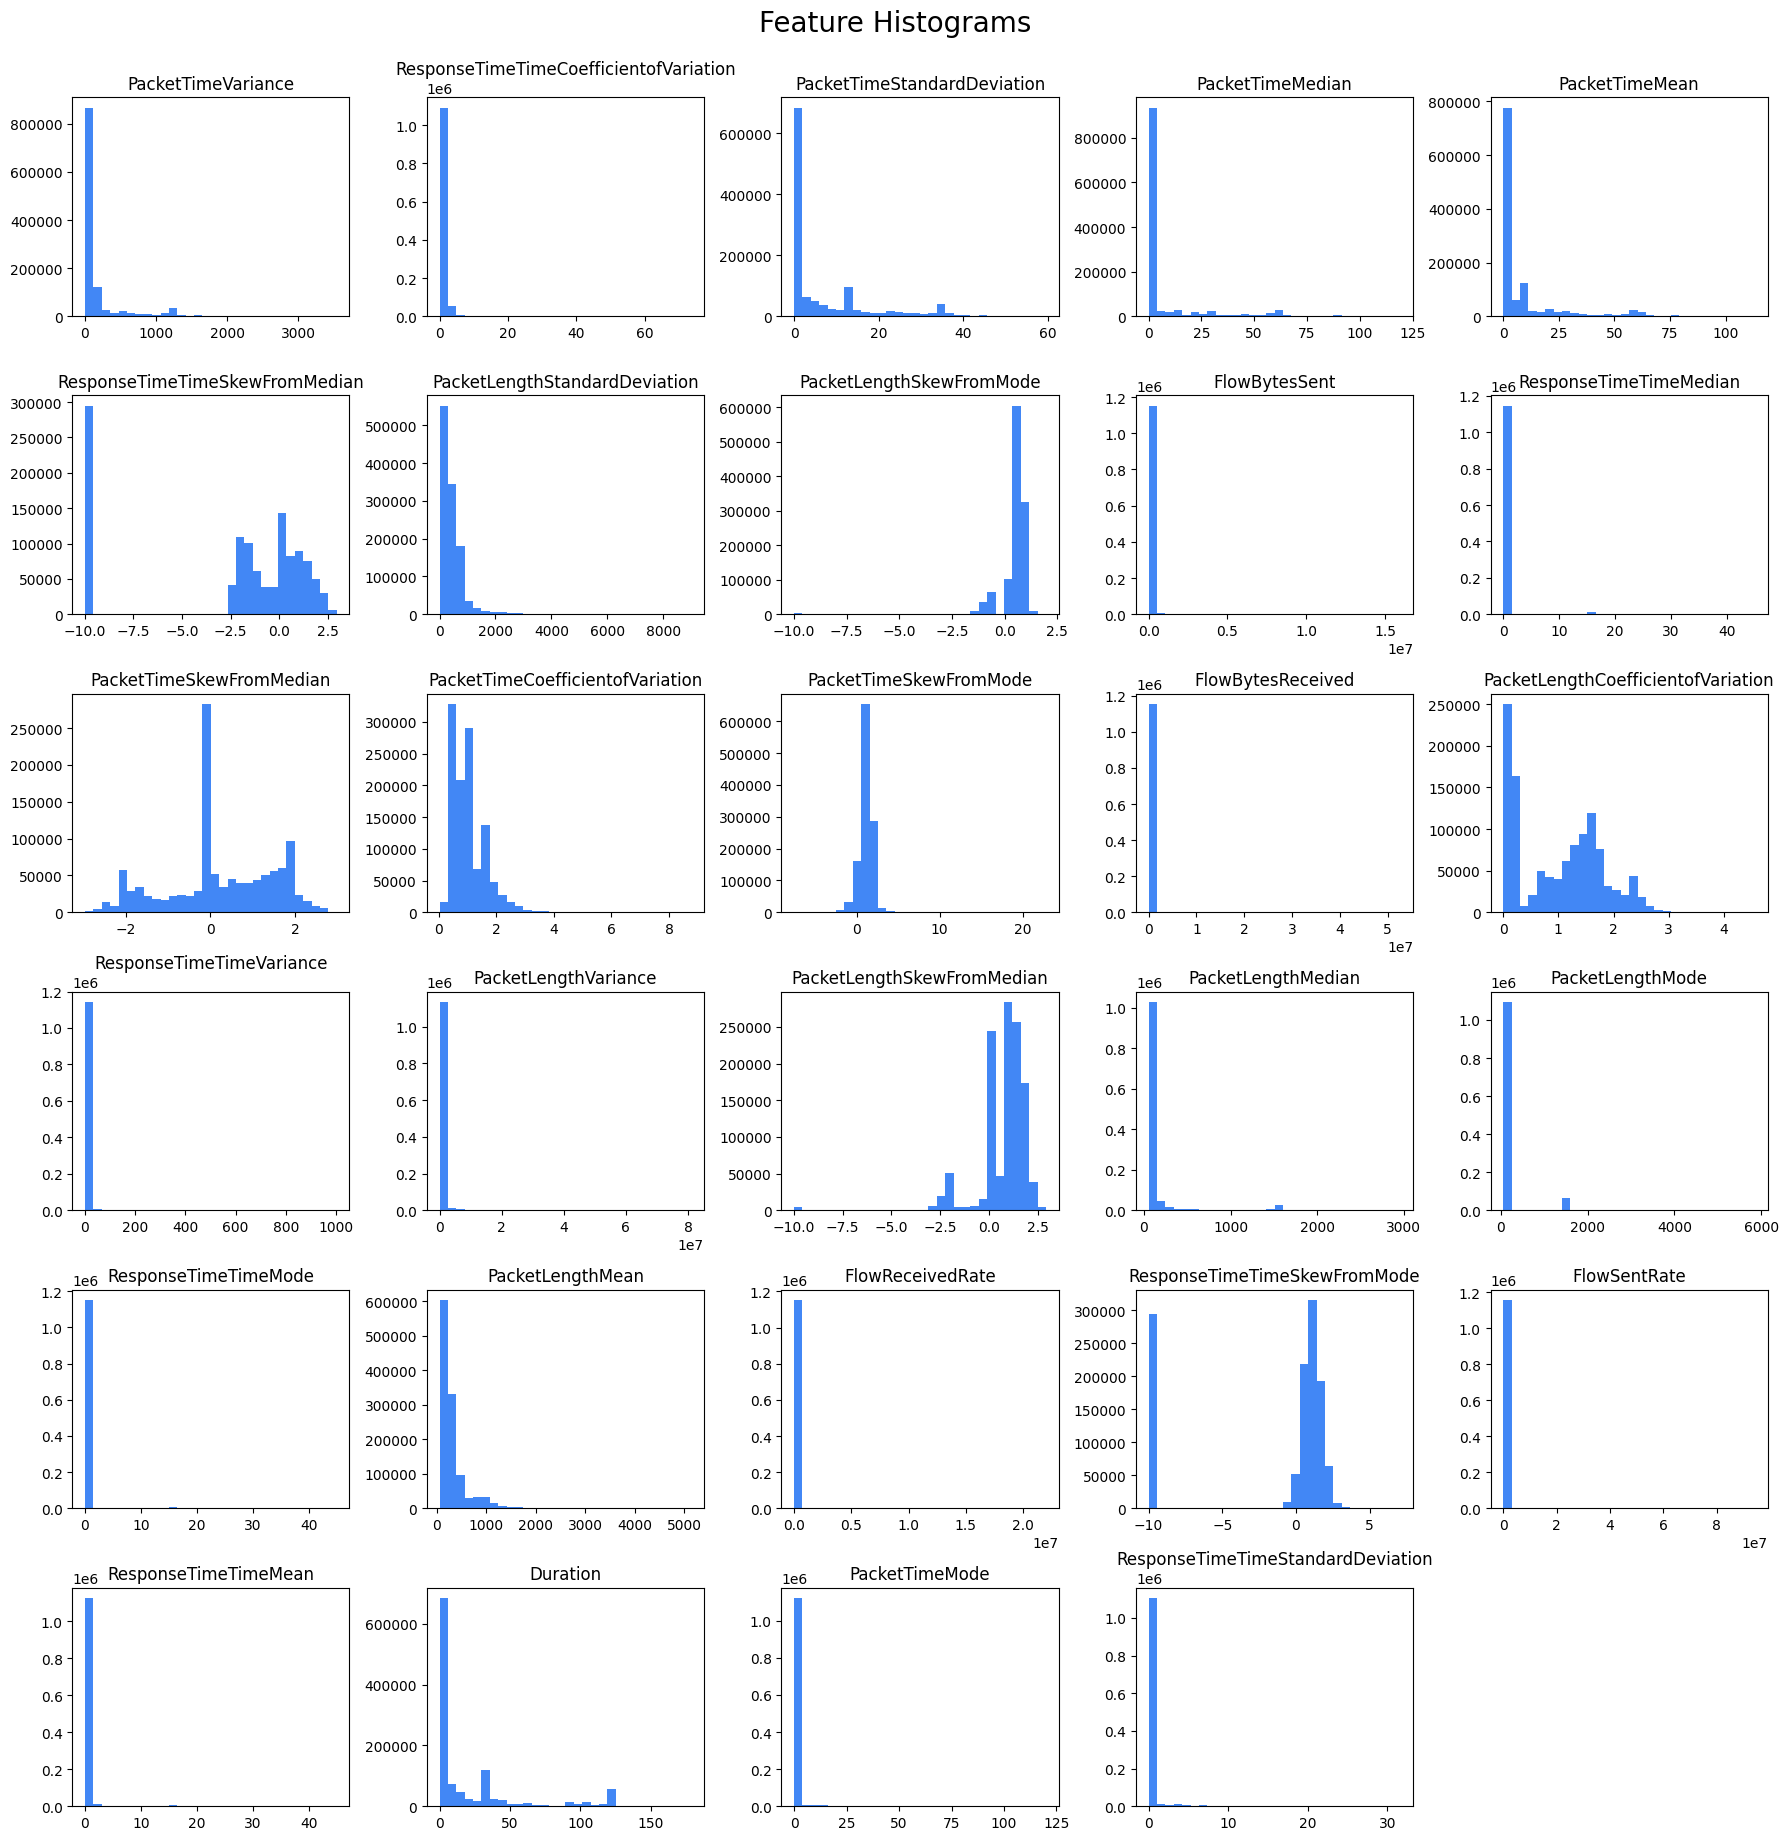

In [ ]:
# Plot histograms for all features
features = [col for col in df.columns if col != 'Label']

df[features].hist(bins=30, figsize=(18, 18), color='#4287f5', grid=False)
plt.tight_layout()
plt.suptitle('Feature Histograms', fontsize=20, y=1.02)
plt.show()

## Correlation Matrix and Heatmap

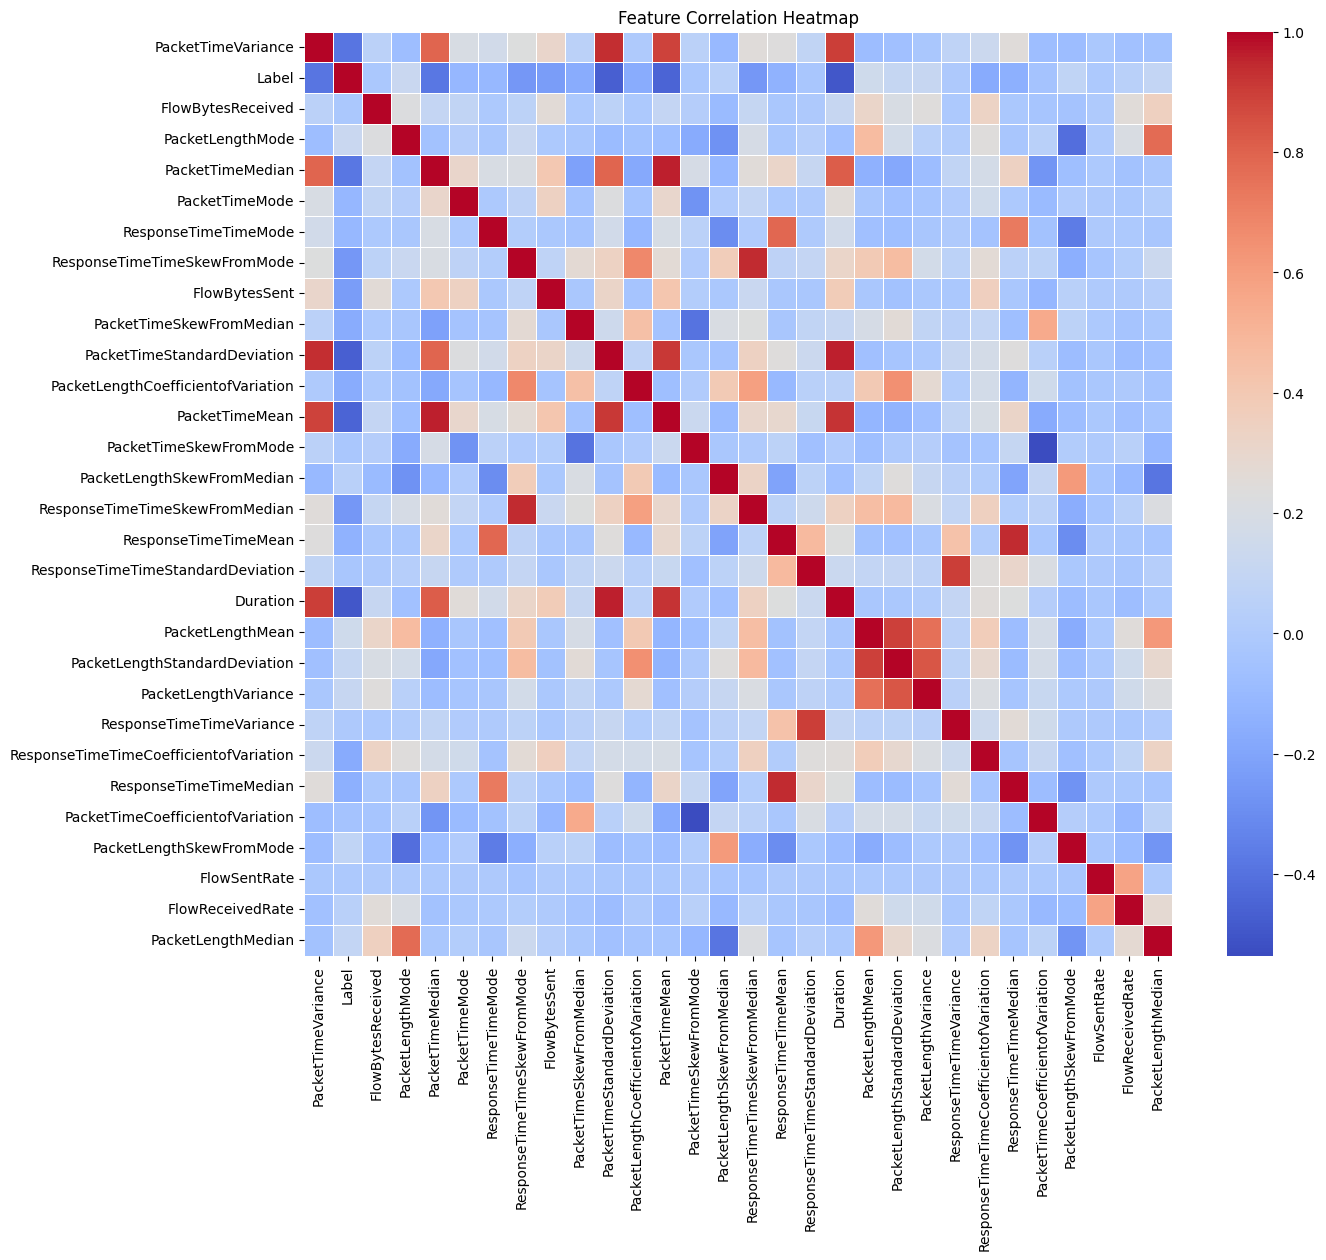

In [ ]:
# Calculate the correlation matrix
corr = df_02.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# Feature Engineering

### Raw Data Split

In [ ]:
# Features separation (X) and target (y) after initial preprocessing
X = df_02.drop('Label', axis=1)
y = df_02['Label']

In [ ]:
# Data split into training and testing (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Oversampling (SMOTE)

In [ ]:
# Apply SMOTE oversampling
oversampler = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Class distribution before and after oversampling
print("Original training set shape:", Counter(y_train))
print("Resampled training set shape:", Counter(y_train_oversampled))

Original training set shape: Counter({2: 711783, 1: 199808, 0: 15695})
Resampled training set shape: Counter({2: 711783, 1: 711783, 0: 711783})


## Undersampligng

In [ ]:
# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_downsampled, y_train_downsampled = undersampler.fit_resample(X_train, y_train)
print("Original training set shape:", Counter(y_train))
print("Resampled training set shape:", Counter(y_train_downsampled))

Original training set shape: Counter({2: 711783, 1: 199808, 0: 15695})
Resampled training set shape: Counter({0: 15695, 1: 15695, 2: 15695})


## Hybrid SMOTE + undersampler

In [ ]:
# Define undersampler
undersampler = RandomUnderSampler(sampling_strategy={2: 250000}, random_state=42)

# Define oversampler
oversampler = SMOTE(sampling_strategy={0: 250000, 1: 250000}, random_state=42)

# Combine into pipeline
pipeline = Pipeline(steps=[('undersample', undersampler),
                           ('oversample', oversampler)])

# Apply to training data
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

print("Original training set shape:", Counter(y_train))
print("Resampled training set shape:", Counter(y_train_balanced))


Original training set shape: Counter({2: 711783, 1: 199808, 0: 15695})
Resampled training set shape: Counter({0: 250000, 1: 250000, 2: 250000})


## Standard Scaler

### Standard Scaler Split

In [ ]:
df_scaled = X.copy()

In [ ]:
# Split with reproducibility
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(df_scaled[features], y, test_size=0.2, random_state=42)

In [ ]:
# Apply Standard Scaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

NameError: name 'X_train' is not defined

# Machine Learning - classification models training

## Models: Random Forest, Naive Bayes, Logistic Regression, XGBoost

In [ ]:
def mapping_confusion_matrix(y_test, y_pred,model,label):

    # Label mapping
    label_mapping = {0: 'Benign', 1: 'Malicious', 2: 'NonDoH'}

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create label list in the correct order
    labels = [label_mapping[i] for i in sorted(label_mapping)]

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model.__class__.__name__} - {label}")
    plt.tight_layout()
    plt.show()

In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model, label):
    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Print evaluation results
    print(f"Label: {label}")
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    mapping_confusion_matrix(y_test, y_pred, model, label)


In [ ]:
# Model list
models = [
    RandomForestClassifier(random_state=42),
    GaussianNB(),
    LogisticRegression(max_iter=1000, random_state=42),
    XGBClassifier()
]

In [ ]:
# Train and evaluate all models
for model in models:
    train_and_evaluate(X_train, y_train, X_test, y_test, model, "Raw Data")
    train_and_evaluate(X_train_std, y_train_std,  X_test_std, y_test_std, model, "Standard Scaler")
    train_and_evaluate(X_train_oversampled, y_train_oversampled, X_test, y_test, model, "SMOTE Oversampling")
    train_and_evaluate(X_train_downsampled, y_train_downsampled, X_test, y_test, model, "Downsampling")
    train_and_evaluate(X_train_balanced, y_train_balanced, X_test, y_test, model, "Hybrid SMOTE+downsampling")


TypeError: 'module' object is not iterable

# Machine learning - Neural Networks

## Feedforward Neural Network (MLP)


### Raw data

In [ ]:
y_onehot = to_categorical(y_train, num_classes=3)

In [ ]:
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes → softmax output
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Train the model
model.fit(X_train, y_onehot, epochs=70, batch_size=1024, validation_split=0.1) # increased from 20 to 70

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7679 - loss: 1252.5756 - val_accuracy: 0.6724 - val_loss: 1165.9471
Epoch 2/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8228 - loss: 365.2892 - val_accuracy: 0.8796 - val_loss: 95.3783
Epoch 3/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8412 - loss: 147.3267 - val_accuracy: 0.7734 - val_loss: 87.1810
Epoch 4/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8544 - loss: 123.5632 - val_accuracy: 0.8860 - val_loss: 91.7669
Epoch 5/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8616 - loss: 105.6066 - val_accuracy: 0.7848 - val_loss: 90.1403
Epoch 6/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8692 - loss: 93.7292 - val_accuracy: 0.9116 - val_loss: 54.8166
Epoch 7/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8784 - loss: 76.0540 - val_accuracy: 0.8996 - val_loss: 53.3303
Epoch 8/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8915 - loss: 4

In [ ]:
y_test_onehot = to_categorical(y_test, num_classes=3)

In [ ]:
# Step 9: Evaluate the model
loss, acc = model.evaluate(X_test, y_test_onehot)
print("Test accuracy:", acc)

7245/7245 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7907 - loss: 0.4454
Test accuracy: 0.7900587320327759


7245/7245 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.28      0.43      3949
           1       0.99      0.08      0.16     49911
           2       0.79      1.00      0.88    177962

    accuracy                           0.79    231822
   macro avg       0.90      0.45      0.49    231822
weighted avg       0.83      0.79      0.72    231822



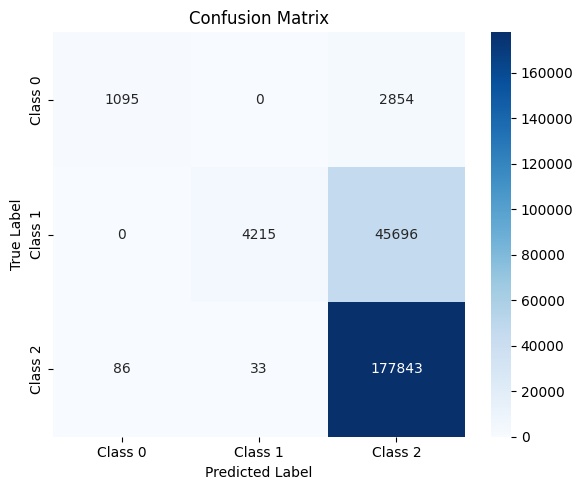

In [ ]:
# Step 1: Get model predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)         # Convert softmax probs to class indices
y_true = np.argmax(y_test_onehot, axis=1)        # Convert one-hot encoded labels to class indices

# Step 2: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Classification report (optional but useful)
print(classification_report(y_true, y_pred))

# Step 4: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(3)],
            yticklabels=[f"Class {i}" for i in range(3)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

7245/7245 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
              precision    recall  f1-score   support

      Benign       0.93      0.28      0.43      3949
   Malicious       0.99      0.08      0.16     49911
      NonDoH       0.79      1.00      0.88    177962

    accuracy                           0.79    231822
   macro avg       0.90      0.45      0.49    231822
weighted avg       0.83      0.79      0.72    231822



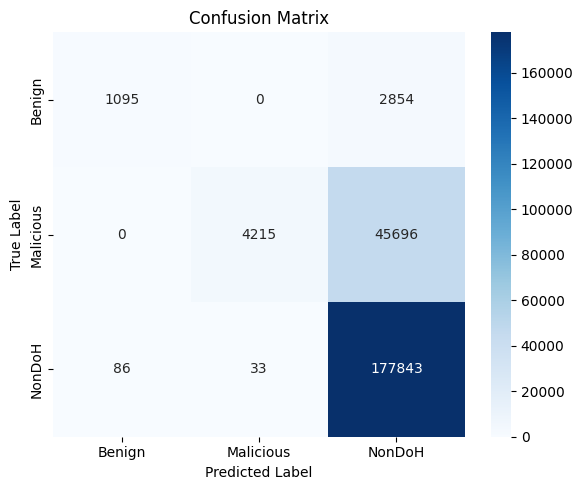

In [ ]:
# Predict class indices from the model
y_pred_probs = model.predict(X_test)               # Shape: (n_samples, 3)
y_pred = np.argmax(y_pred_probs, axis=1)           # Convert softmax to class labels

# Your true labels (already encoded as 0, 1, 2)
# Assuming y_test was not one-hot encoded
# If y_test is shape (n_samples, 1), flatten it
y_true = y_test.ravel() if y_test.ndim == 2 else y_test

# Define class names based on your label encoding
class_names = ['Benign', 'Malicious', 'NonDoH']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Standard Scaler

In [ ]:
y_onehot = to_categorical(y_train_std, num_classes=3)

In [ ]:
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_std.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes → softmax output
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Train the model
model.fit(X_train_std, y_onehot, epochs=70, batch_size=1024, validation_split=0.1) #we increased from 20 to 70

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9124 - loss: 0.2653 - val_accuracy: 0.9672 - val_loss: 0.1072
Epoch 2/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9687 - loss: 0.0990 - val_accuracy: 0.9750 - val_loss: 0.0789
Epoch 3/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9774 - loss: 0.0760 - val_accuracy: 0.9818 - val_loss: 0.0633
Epoch 4/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9818 - loss: 0.0629 - val_accuracy: 0.9838 - val_loss: 0.0558
Epoch 5/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9842 - loss: 0.0554 - val_accuracy: 0.9857 - val_loss: 0.0497
Epoch 6/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9855 - loss: 0.0504 - val_accuracy: 0.9866 - val_loss: 0.0460
Epoch 7/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9864 - loss: 0.0475 - val_accuracy: 0.9861 - val_loss: 0.0454
Epoch 8/70
815/815 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9870 - loss: 0.0448 - val_accuracy: 

In [ ]:
y_test_onehot = to_categorical(y_test_std, num_classes=3)

In [ ]:
# Step 9: Evaluate the model
loss, acc = model.evaluate(X_test_std, y_test_onehot)
print("Test accuracy:", acc)

7245/7245 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9937 - loss: 0.0231
Test accuracy: 0.9935510754585266


7245/7245 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      3949
           1       1.00      1.00      1.00     49911
           2       0.99      1.00      1.00    177962

    accuracy                           0.99    231822
   macro avg       0.96      0.93      0.95    231822
weighted avg       0.99      0.99      0.99    231822



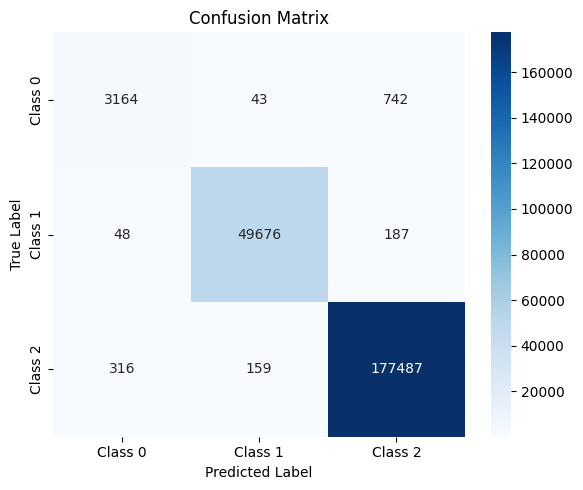

In [ ]:
# Step 1: Get model predictions
y_pred_probs = model.predict(X_test_std)
y_pred = np.argmax(y_pred_probs, axis=1)         # Convert softmax probs to class indices
y_true = np.argmax(y_test_onehot, axis=1)        # Convert one-hot encoded labels to class indices

# Step 2: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Classification report (optional but useful)
print(classification_report(y_true, y_pred))

# Step 4: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(3)],
            yticklabels=[f"Class {i}" for i in range(3)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

7245/7245 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
              precision    recall  f1-score   support

      Benign       0.90      0.80      0.85      3949
   Malicious       1.00      1.00      1.00     49911
      NonDoH       0.99      1.00      1.00    177962

    accuracy                           0.99    231822
   macro avg       0.96      0.93      0.95    231822
weighted avg       0.99      0.99      0.99    231822



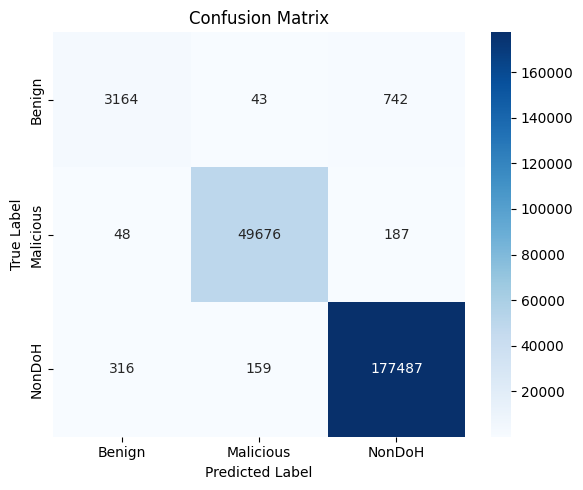

In [ ]:
# Predict class indices from the model
y_pred_probs = model.predict(X_test_std)               # Shape: (n_samples, 3)
y_pred = np.argmax(y_pred_probs, axis=1)           # Convert softmax to class labels

# Your true labels (already encoded as 0, 1, 2)
# Assuming y_test was not one-hot encoded
# If y_test is shape (n_samples, 1), flatten it
y_true = y_test.ravel() if y_test.ndim == 2 else y_test

# Define class names based on your label encoding
class_names = ['Benign', 'Malicious', 'NonDoH']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Downsampling

In [ ]:
y_onehot = to_categorical(y_train_downsampled, num_classes=3)

NameError: name 'y_train_downsampled' is not defined

In [ ]:
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_downsampled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes → softmax output
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Train the model
model.fit(X_train_downsampled, y_onehot, epochs=70, batch_size=1024, validation_split=0.1) #we increased from 20 to 70

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3767 - loss: 5961.1489 - val_accuracy: 0.4331 - val_loss: 1218.7612
Epoch 2/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5657 - loss: 321.3721 - val_accuracy: 0.2892 - val_loss: 1498.9202
Epoch 3/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6249 - loss: 486.9868 - val_accuracy: 0.3238 - val_loss: 1011.4269
Epoch 4/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6436 - loss: 159.6247 - val_accuracy: 0.7751 - val_loss: 391.8050
Epoch 5/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6480 - loss: 192.7545 - val_accuracy: 0.4483 - val_loss: 997.9020
Epoch 6/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6950 - loss: 168.6641 - val_accuracy: 0.8133 - val_loss: 393.3783
Epoch 7/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6919 - loss: 153.0454 - val_accuracy: 0.6831 - val_loss: 774.6769
Epoch 8/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6976 - loss: 233.620

In [ ]:
y_test_onehot = to_categorical(y_test, num_classes=3)

In [ ]:
# Step 9: Evaluate the model
loss, acc = model.evaluate(X_test, y_test_onehot)
print("Test accuracy:", acc)

7245/7245 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6589 - loss: 106.6016
Test accuracy: 0.6585656404495239


7245/7245 ━━━━━━━━━━━━━━━━━━━━ 7s 972us/step
              precision    recall  f1-score   support

           0       0.12      0.82      0.21      3949
           1       0.45      0.92      0.61     49911
           2       1.00      0.58      0.73    177962

    accuracy                           0.66    231822
   macro avg       0.52      0.77      0.52    231822
weighted avg       0.86      0.66      0.70    231822



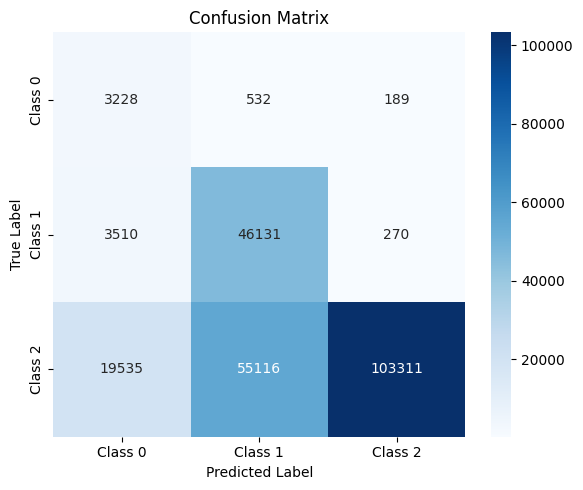

In [ ]:
# Step 1: Get model predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)         # Convert softmax probs to class indices
y_true = np.argmax(y_test_onehot, axis=1)        # Convert one-hot encoded labels to class indices

# Step 2: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Classification report (optional but useful)
print(classification_report(y_true, y_pred))

# Step 4: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(3)],
            yticklabels=[f"Class {i}" for i in range(3)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

7245/7245 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
              precision    recall  f1-score   support

      Benign       0.12      0.82      0.21      3949
   Malicious       0.45      0.92      0.61     49911
      NonDoH       1.00      0.58      0.73    177962

    accuracy                           0.66    231822
   macro avg       0.52      0.77      0.52    231822
weighted avg       0.86      0.66      0.70    231822



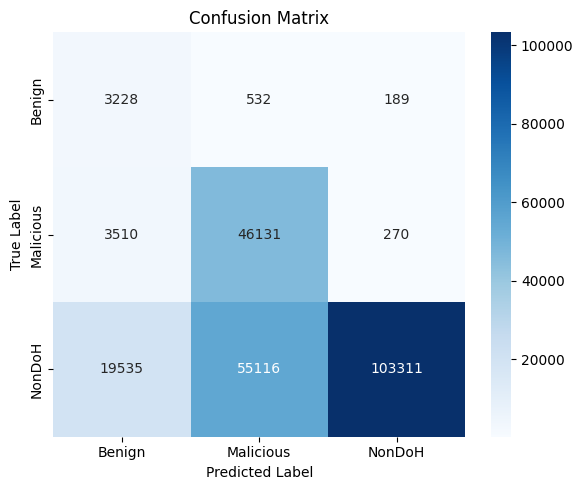

In [ ]:
# Predict class indices from the model
y_pred_probs = model.predict(X_test)               # Shape: (n_samples, 3)
y_pred = np.argmax(y_pred_probs, axis=1)           # Convert softmax to class labels

# Your true labels (already encoded as 0, 1, 2)
# Assuming y_test was not one-hot encoded
# If y_test is shape (n_samples, 1), flatten it
y_true = y_test.ravel() if y_test.ndim == 2 else y_test

# Define class names based on your label encoding
class_names = ['Benign', 'Malicious', 'NonDoH']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Oversampling

In [ ]:
y_onehot = to_categorical(y_train_oversampled, num_classes=3)

NameError: name 'y_train_oversampled' is not defined

In [ ]:
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_oversampled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes → softmax output
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Train the model
model.fit(X_train_oversampled, y_onehot, epochs=70, batch_size=1024, validation_split=0.1) #we increased from 20 to 70

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6522 - loss: 1192.6333 - val_accuracy: 0.5713 - val_loss: 141.6368
Epoch 2/70
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7503 - loss: 102.8450 - val_accuracy: 0.9554 - val_loss: 8.8116
Epoch 3/70
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7820 - loss: 71.3979 - val_accuracy: 0.9503 - val_loss: 7.5061
Epoch 4/70
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8066 - loss: 47.2169 - val_accuracy: 0.6717 - val_loss: 108.1835
Epoch 5/70
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8213 - loss: 34.7925 - val_accuracy: 0.3959 - val_loss: 73.1341
Epoch 6/70
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8327 - loss: 30.6282 - val_accuracy: 0.9442 - val_loss: 3.9634
Epoch 7/70
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8428 - loss: 19.0846 - val_accuracy: 0.7316 - val_loss: 35.7133
Epoch 8/70
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 

In [ ]:
y_test_onehot = to_categorical(y_test, num_classes=3)

ValueError: invalid literal for int() with base 10: 'NonDoH'

In [ ]:
# Step 9: Evaluate the model
loss, acc = model.evaluate(X_test, y_test_onehot)
print("Test accuracy:", acc)

7245/7245 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9437 - loss: 0.2232
Test accuracy: 0.9435946345329285


7245/7245 ━━━━━━━━━━━━━━━━━━━━ 7s 952us/step
              precision    recall  f1-score   support

           0       0.28      0.90      0.42      3949
           1       0.94      0.98      0.96     49911
           2       1.00      0.94      0.97    177962

    accuracy                           0.94    231822
   macro avg       0.74      0.94      0.78    231822
weighted avg       0.97      0.94      0.95    231822



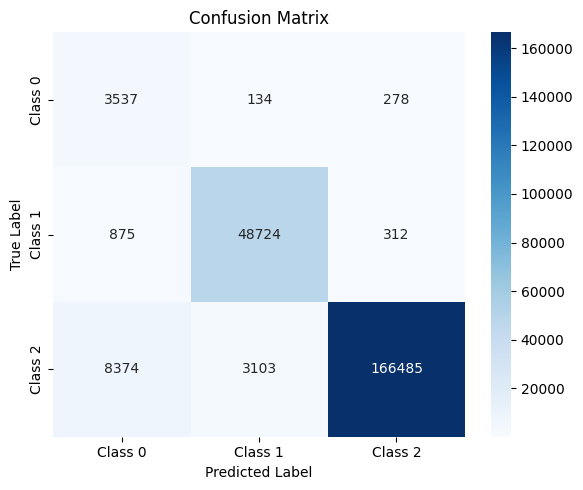

In [ ]:
# Step 1: Get model predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)         # Convert softmax probs to class indices
y_true = np.argmax(y_test_onehot, axis=1)        # Convert one-hot encoded labels to class indices

# Step 2: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Classification report (optional but useful)
print(classification_report(y_true, y_pred))

# Step 4: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(3)],
            yticklabels=[f"Class {i}" for i in range(3)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

7245/7245 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
              precision    recall  f1-score   support

      Benign       0.28      0.90      0.42      3949
   Malicious       0.94      0.98      0.96     49911
      NonDoH       1.00      0.94      0.97    177962

    accuracy                           0.94    231822
   macro avg       0.74      0.94      0.78    231822
weighted avg       0.97      0.94      0.95    231822



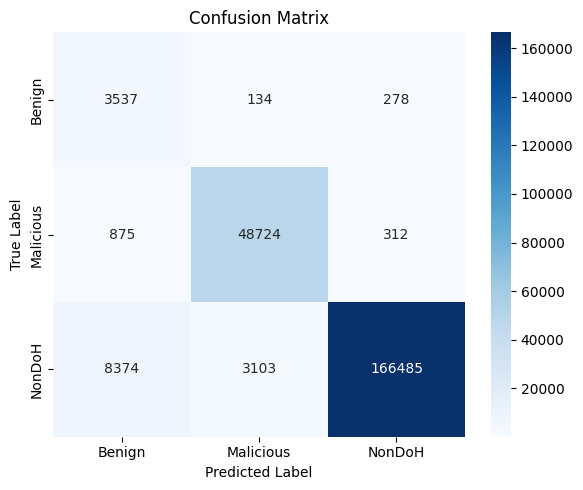

In [ ]:
# Predict class indices from the model
y_pred_probs = model.predict(X_test)               # Shape: (n_samples, 3)
y_pred = np.argmax(y_pred_probs, axis=1)           # Convert softmax to class labels

# Your true labels (already encoded as 0, 1, 2)
# Assuming y_test was not one-hot encoded
# If y_test is shape (n_samples, 1), flatten it
y_true = y_test.ravel() if y_test.ndim == 2 else y_test

# Define class names based on your label encoding
class_names = ['Benign', 'Malicious', 'NonDoH']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# RNN

## Raw Data

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - accuracy: 0.8466 - loss: 0.3694 - val_accuracy: 0.8525 - val_loss: 0.3446
Epoch 2/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 151s 4ms/step - accuracy: 0.8504 - loss: 0.3558 - val_accuracy: 0.8507 - val_loss: 0.3535
Epoch 3/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 0.8516 - loss: 0.3549 - val_accuracy: 0.8517 - val_loss: 0.3494
Epoch 4/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - accuracy: 0.8523 - loss: 0.3484 - val_accuracy: 0.8538 - val_loss: 0.3466
Epoch 5/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 149s 4ms/step - accuracy: 0.8526 - loss: 0.3481 - val_accuracy: 0.8547 - val_loss: 0.3411
Epoch 6/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - accuracy: 0.8525 - loss: 0.3412 - val_accuracy: 0.8530 - val_loss: 0.3490
Epoch 7/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 111s 4ms/step - accuracy: 0.8529 - loss: 0.3395 - val_accuracy: 0.8552 - val_loss: 0.3430
Epoch 8/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - ac

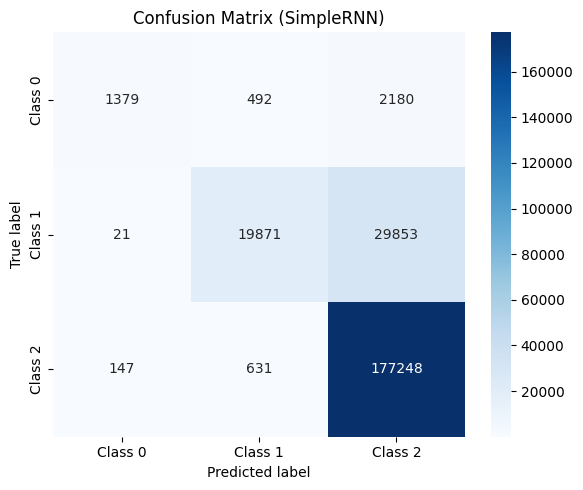

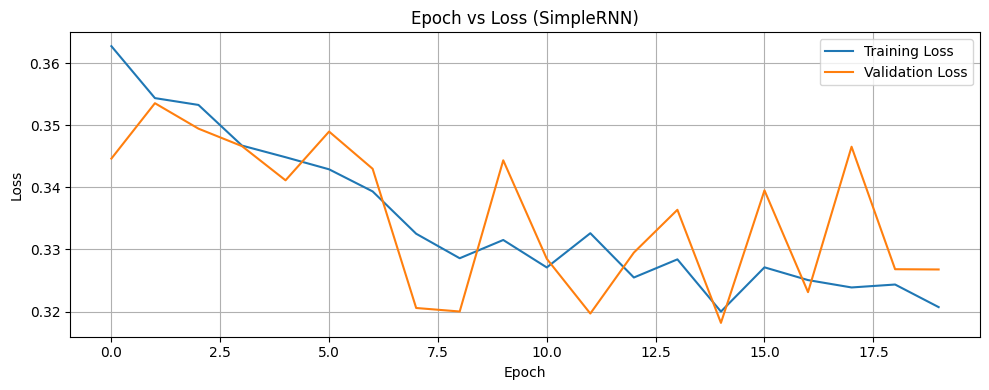

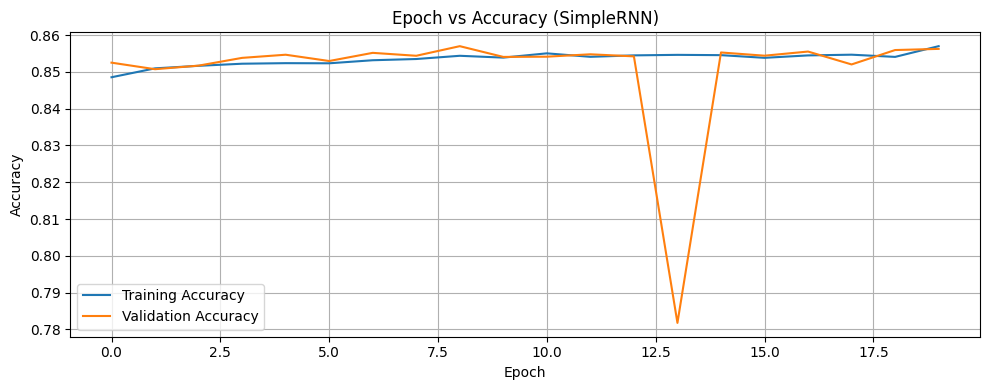

In [ ]:
# --- Data shaping (unchanged logic; just renamed for clarity) ---
# Shape: (samples, timesteps=1, features)
X_train_rnn = np.asarray(X_train, dtype=np.float32).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rnn  = np.asarray(X_test,  dtype=np.float32).reshape(X_test.shape[0],  1, X_test.shape[1])

# Labels as integers
y_train_int = np.asarray(y_train, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

# --- RNN model (SimpleRNN replaces LSTM) ---
model = models.Sequential([
    layers.SimpleRNN(
        128,                      # number of recurrent units
        activation='tanh',        # state activation (default)
        input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])
        # recurrent_activation='sigmoid'  # default; keep unless you have a reason to change
    ),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_rnn, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_rnn, y_test_int),
    verbose=1
)

# --- EVALUATE ---
loss, acc = model.evaluate(X_test_rnn, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# --- PREDICT & REPORT ---
y_pred_probs = model.predict(X_test_rnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test_int

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, digits=4))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_true, y_pred)
class_names = [f"Class {i}" for i in range(3)]  # customize if you have real names

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (SimpleRNN)")
plt.tight_layout()
plt.show()

# --- TRAINING CURVES ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (SimpleRNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy (SimpleRNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Standar Scaler

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - accuracy: 0.9581 - loss: 0.1274 - val_accuracy: 0.9835 - val_loss: 0.0577
Epoch 2/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.9829 - loss: 0.0583 - val_accuracy: 0.9830 - val_loss: 0.0565
Epoch 3/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.9865 - loss: 0.0469 - val_accuracy: 0.9872 - val_loss: 0.0459
Epoch 4/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 109s 4ms/step - accuracy: 0.9880 - loss: 0.0415 - val_accuracy: 0.9892 - val_loss: 0.0393
Epoch 5/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 0.9891 - loss: 0.0379 - val_accuracy: 0.9903 - val_loss: 0.0369
Epoch 6/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 113s 4ms/step - accuracy: 0.9898 - loss: 0.0353 - val_accuracy: 0.9898 - val_loss: 0.0377
Epoch 7/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 114s 4ms/step - accuracy: 0.9905 - loss: 0.0332 - val_accuracy: 0.9907 - val_loss: 0.0350
Epoch 8/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - ac

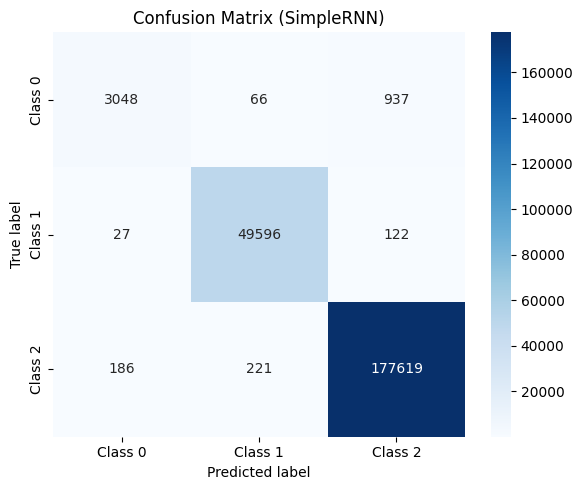

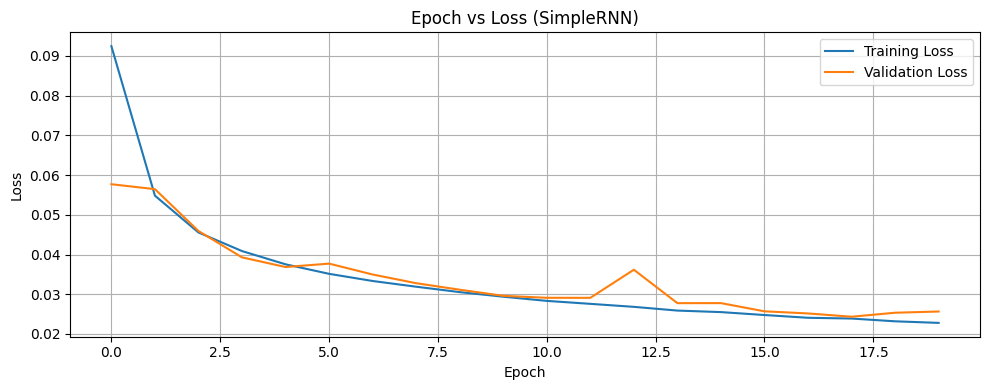

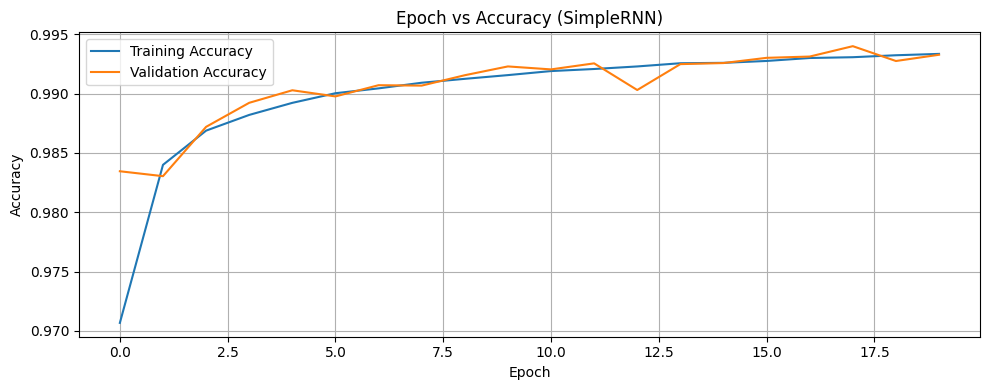

In [ ]:
# --- Data shaping (unchanged logic; just renamed for clarity) ---
# Shape: (samples, timesteps=1, features)
X_train_rnn = np.asarray(X_train_std, dtype=np.float32).reshape(X_train_std.shape[0], 1, X_train.shape[1])
X_test_rnn  = np.asarray(X_test_std,  dtype=np.float32).reshape(X_test_std.shape[0],  1, X_test.shape[1])

# Labels as integers
y_train_int = np.asarray(y_train, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

# --- RNN model (SimpleRNN replaces LSTM) ---
model = models.Sequential([
    layers.SimpleRNN(
        128,                      # number of recurrent units
        activation='tanh',        # state activation (default)
        input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])
        # recurrent_activation='sigmoid'  # default; keep unless you have a reason to change
    ),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_rnn, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_rnn, y_test_int),
    verbose=1
)

# --- EVALUATE ---
loss, acc = model.evaluate(X_test_rnn, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# --- PREDICT & REPORT ---
y_pred_probs = model.predict(X_test_rnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test_int

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, digits=4))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_true, y_pred)
class_names = [f"Class {i}" for i in range(3)]  # customize if you have real names

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (SimpleRNN)")
plt.tight_layout()
plt.show()

# --- TRAINING CURVES ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (SimpleRNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy (SimpleRNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SMOTE

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 272s 4ms/step - accuracy: 0.7210 - loss: 0.6035 - val_accuracy: 0.6923 - val_loss: 0.6003
Epoch 2/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 331s 4ms/step - accuracy: 0.7403 - loss: 0.5798 - val_accuracy: 0.6508 - val_loss: 0.5996
Epoch 3/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 311s 4ms/step - accuracy: 0.7456 - loss: 0.5720 - val_accuracy: 0.6918 - val_loss: 0.5892
Epoch 4/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 256s 4ms/step - accuracy: 0.7421 - loss: 0.5751 - val_accuracy: 0.5773 - val_loss: 0.6158
Epoch 5/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 269s 4ms/step - accuracy: 0.7325 - loss: 0.5855 - val_accuracy: 0.6766 - val_loss: 0.6205
Epoch 6/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 266s 4ms/step - accuracy: 0.7491 - loss: 0.5742 - val_accuracy: 0.6060 - val_loss: 0.7057
Epoch 7/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 286s 4ms/step - accuracy: 0.7530 - loss: 0.5722 - val_accuracy: 0.7315 - val_loss: 0.6061
Epoch 8/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 327s 4ms/step - ac

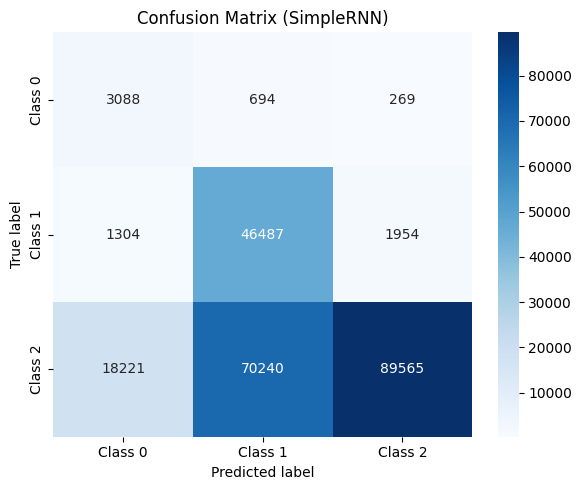

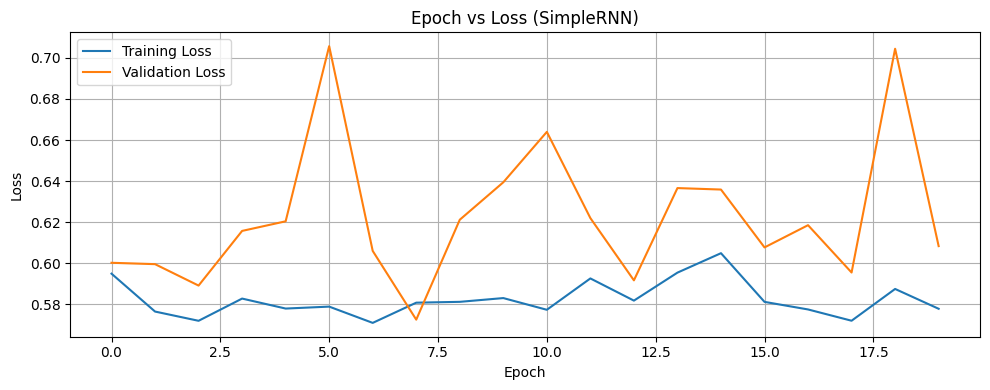

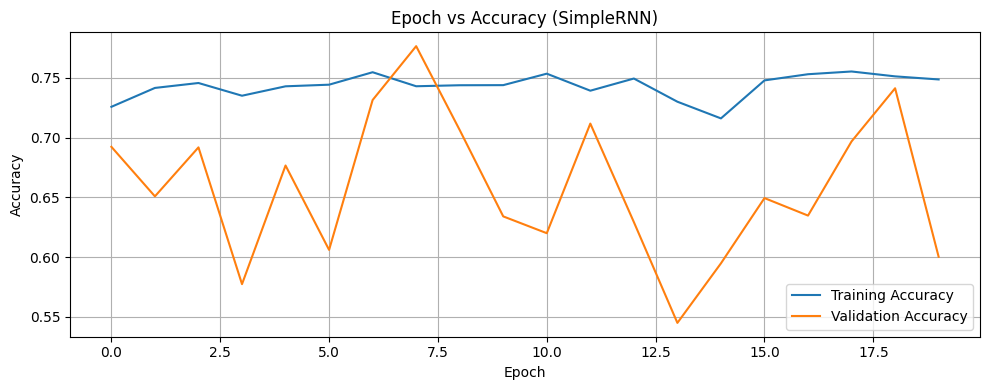

In [ ]:
# --- Data shaping (unchanged logic; just renamed for clarity) ---
# Shape: (samples, timesteps=1, features)
X_train_rnn = np.asarray(X_train_oversampled, dtype=np.float32).reshape(X_train_oversampled.shape[0], 1, X_train.shape[1])
X_test_rnn  = np.asarray(X_test,  dtype=np.float32).reshape(X_test.shape[0],  1, X_test.shape[1])

# Labels as integers
y_train_int = np.asarray(y_train_oversampled, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

# --- RNN model (SimpleRNN replaces LSTM) ---
model = models.Sequential([
    layers.SimpleRNN(
        128,                      # number of recurrent units
        activation='tanh',        # state activation (default)
        input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])
        # recurrent_activation='sigmoid'  # default; keep unless you have a reason to change
    ),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_rnn, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_rnn, y_test_int),
    verbose=1
)

# --- EVALUATE ---
loss, acc = model.evaluate(X_test_rnn, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# --- PREDICT & REPORT ---
y_pred_probs = model.predict(X_test_rnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test_int

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, digits=4))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_true, y_pred)
class_names = [f"Class {i}" for i in range(3)]  # customize if you have real names

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (SimpleRNN)")
plt.tight_layout()
plt.show()

# --- TRAINING CURVES ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (SimpleRNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy (SimpleRNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Downsampling

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1472/1472 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.6932 - loss: 0.6706 - val_accuracy: 0.5875 - val_loss: 0.6899
Epoch 2/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.7146 - loss: 0.6191 - val_accuracy: 0.5828 - val_loss: 0.6826
Epoch 3/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.7037 - loss: 0.6188 - val_accuracy: 0.5971 - val_loss: 0.6828
Epoch 4/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7163 - loss: 0.6070 - val_accuracy: 0.5777 - val_loss: 0.6351
Epoch 5/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.7140 - loss: 0.6073 - val_accuracy: 0.7883 - val_loss: 0.5462
Epoch 6/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.7005 - loss: 0.6165 - val_accuracy: 0.5199 - val_loss: 0.7518
Epoch 7/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.7016 - loss: 0.6122 - val_accuracy: 0.6475 - val_loss: 0.6876
Epoch 8/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7228 - loss: 0.59

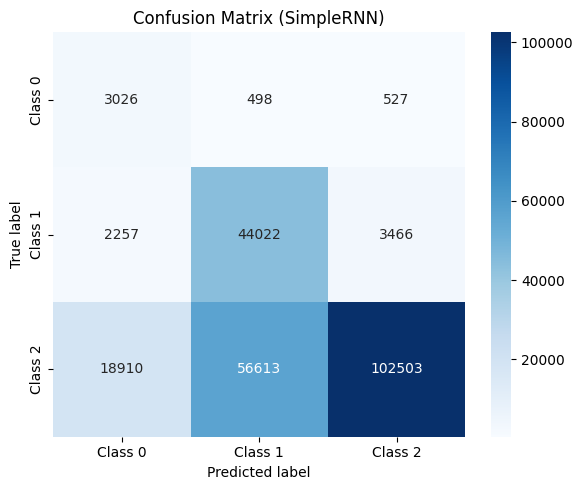

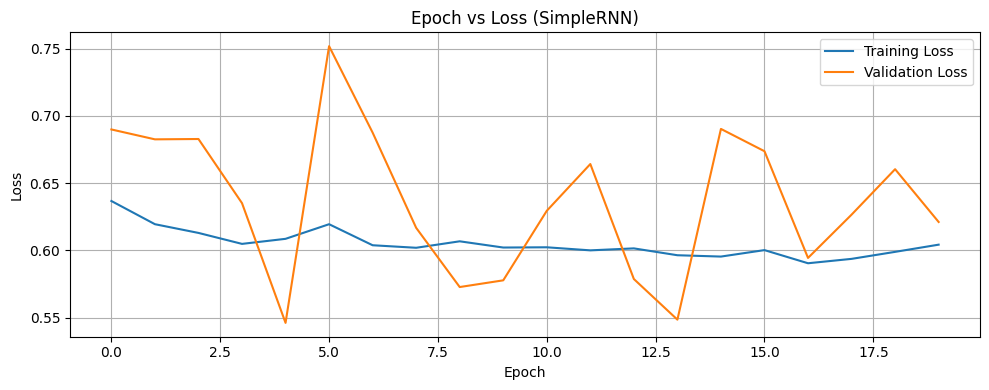

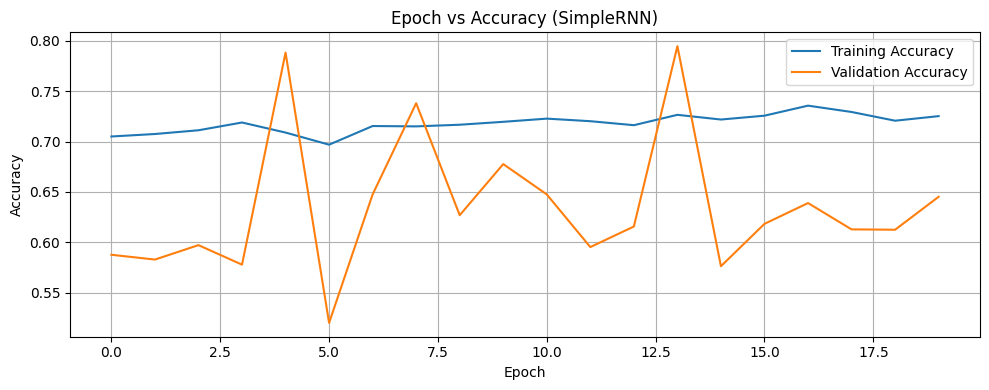

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
import numpy as np

# --- Data shaping (unchanged logic; just renamed for clarity) ---
# Shape: (samples, timesteps=1, features)
X_train_rnn = np.asarray(X_train_downsampled, dtype=np.float32).reshape(X_train_downsampled.shape[0], 1, X_train.shape[1])
X_test_rnn  = np.asarray(X_test,  dtype=np.float32).reshape(X_test.shape[0],  1, X_test.shape[1])

# Labels as integers
y_train_int = np.asarray(y_train_downsampled, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

# --- RNN model (SimpleRNN replaces LSTM) ---
model = models.Sequential([
    layers.SimpleRNN(
        128,                      # number of recurrent units
        activation='tanh',        # state activation (default)
        input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])
        # recurrent_activation='sigmoid'  # default; keep unless you have a reason to change
    ),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_rnn, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_rnn, y_test_int),
    verbose=1
)

# --- EVALUATE ---
loss, acc = model.evaluate(X_test_rnn, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# --- PREDICT & REPORT ---
y_pred_probs = model.predict(X_test_rnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test_int

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, digits=4))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_true, y_pred)
class_names = [f"Class {i}" for i in range(3)]  # customize if you have real names

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (SimpleRNN)")
plt.tight_layout()
plt.show()

# --- TRAINING CURVES ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (SimpleRNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy (SimpleRNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM

## Raw Data

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 219s 7ms/step - accuracy: 0.8454 - loss: 0.3794 - val_accuracy: 0.8503 - val_loss: 0.3670
Epoch 2/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 256s 7ms/step - accuracy: 0.8495 - loss: 0.3661 - val_accuracy: 0.8512 - val_loss: 0.3693
Epoch 3/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 206s 7ms/step - accuracy: 0.8505 - loss: 0.3625 - val_accuracy: 0.8519 - val_loss: 0.3718
Epoch 4/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 204s 7ms/step - accuracy: 0.8512 - loss: 0.3589 - val_accuracy: 0.8540 - val_loss: 0.3498
Epoch 5/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 264s 7ms/step - accuracy: 0.8520 - loss: 0.3477 - val_accuracy: 0.8537 - val_loss: 0.3491
Epoch 6/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 225s 8ms/step - accuracy: 0.8534 - loss: 0.3463 - val_accuracy: 0.8550 - val_loss: 0.3376
Epoch 7/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 204s 7ms/step - accuracy: 0.8533 - loss: 0.3412 - val_accuracy: 0.8534 - val_loss: 0.3334
Epoch 8/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 270s 7ms/step - ac

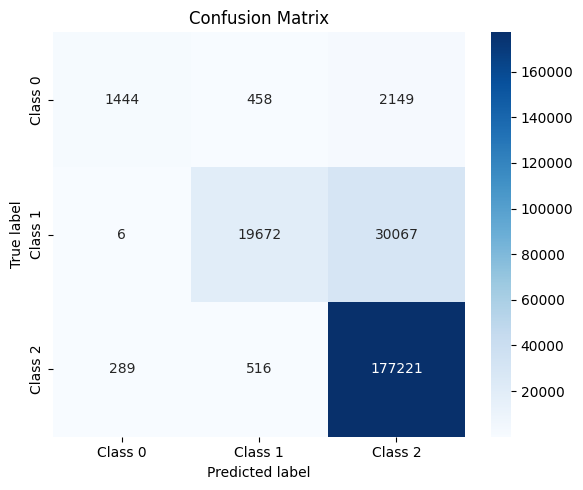

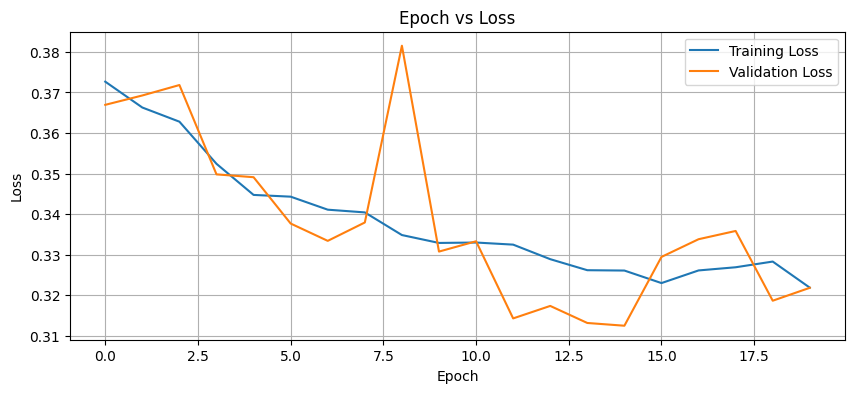

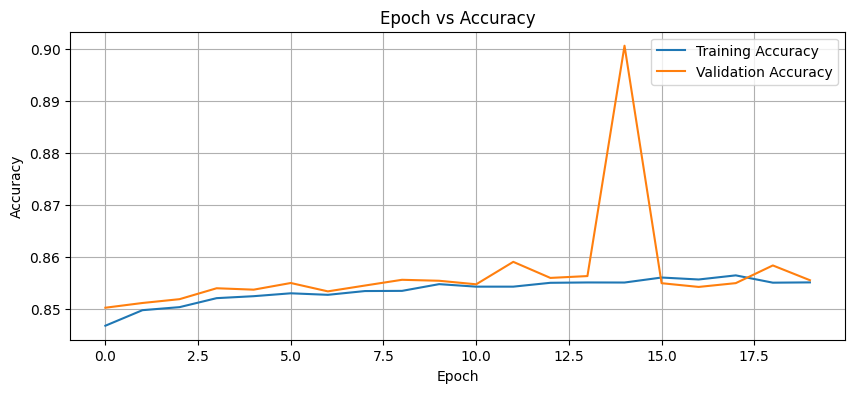

In [ ]:
# X: ensure float32
X_train_lstm = np.asarray(X_train, dtype=np.float32).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm  = np.asarray(X_test,  dtype=np.float32).reshape(X_test.shape[0],  1, X_test.shape[1])

# y: integers 0..2 for both train and val
y_train_int = np.asarray(y_train, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

model = models.Sequential([
    layers.LSTM(128, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_lstm, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_int),
    verbose=1
)


# model: trained Keras model
# X_test_lstm: shape (n_samples, timesteps, n_features)
# y_test_int: integer labels in {0,1,2}

# 1) Evaluate on sparse (integer) labels
loss, acc = model.evaluate(X_test_lstm, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# 2) Predict class probabilities and convert to class indices
y_pred_probs = model.predict(X_test_lstm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3) Ground truth (already integers)
y_true = y_test_int

# 4) Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, digits=4))

# Optional: customize class names if you have them; otherwise generic:
class_names = [f"Class {i}" for i in range(3)]

# 5) Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt

# Assuming `history` is the History object returned by model.fit()

# Plot 1: Epoch vs Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Epoch vs Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Standard Scaler

In [ ]:
# X: ensure float32
X_train_lstm = np.asarray(X_train_std, dtype=np.float32).reshape(X_train_std.shape[0], 1, X_train_std.shape[1])
X_test_lstm  = np.asarray(X_test_std,  dtype=np.float32).reshape(X_test_std.shape[0],  1, X_test_std.shape[1])

# y: integers 0..2 for both train and val
y_train_int = np.asarray(y_train, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

model = models.Sequential([
    layers.LSTM(128, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_lstm, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_int),
    verbose=1
)


Epoch 1/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 211s 7ms/step - accuracy: 0.9590 - loss: 0.1284 - val_accuracy: 0.9841 - val_loss: 0.0541
Epoch 2/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 235s 6ms/step - accuracy: 0.9856 - loss: 0.0496 - val_accuracy: 0.9877 - val_loss: 0.0421
Epoch 3/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 204s 6ms/step - accuracy: 0.9885 - loss: 0.0399 - val_accuracy: 0.9893 - val_loss: 0.0381
Epoch 4/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 203s 6ms/step - accuracy: 0.9898 - loss: 0.0352 - val_accuracy: 0.9911 - val_loss: 0.0335
Epoch 5/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 186s 6ms/step - accuracy: 0.9906 - loss: 0.0322 - val_accuracy: 0.9902 - val_loss: 0.0347
Epoch 6/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 203s 7ms/step - accuracy: 0.9914 - loss: 0.0299 - val_accuracy: 0.9911 - val_loss: 0.0334
Epoch 7/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 213s 7ms/step - accuracy: 0.9919 - loss: 0.0282 - val_accuracy: 0.9909 - val_loss: 0.0332
Epoch 8/20
28978/28978 ━━━━━━━━━━━━━━━━━━━━ 237s 6ms/step - ac

Test loss: 0.0244
Test accuracy: 0.9928
              precision    recall  f1-score   support

           0     0.9414    0.7334    0.8245      4051
           1     0.9963    0.9943    0.9953     49745
           2     0.9928    0.9983    0.9956    178026

    accuracy                         0.9928    231822
   macro avg     0.9768    0.9087    0.9384    231822
weighted avg     0.9927    0.9928    0.9925    231822



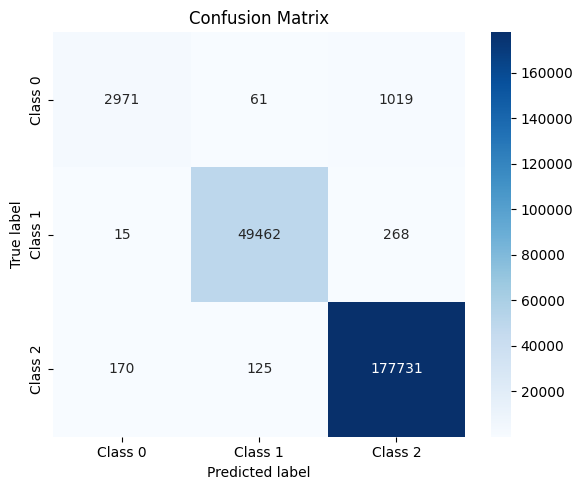

In [ ]:
# model: trained Keras model
# X_test_lstm: shape (n_samples, timesteps, n_features)
# y_test_int: integer labels in {0,1,2}

# 1) Evaluate on sparse (integer) labels
loss, acc = model.evaluate(X_test_lstm, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# 2) Predict class probabilities and convert to class indices
y_pred_probs = model.predict(X_test_lstm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3) Ground truth (already integers)
y_true = y_test_int

# 4) Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, digits=4))

# Optional: customize class names if you have them; otherwise generic:
class_names = [f"Class {i}" for i in range(3)]

# 5) Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


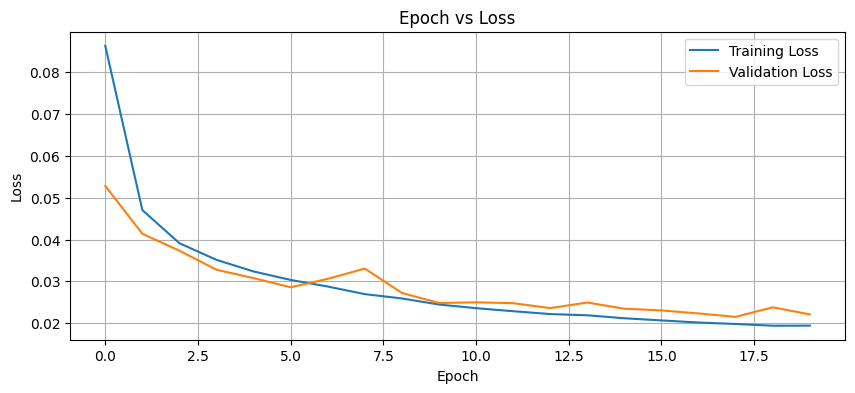

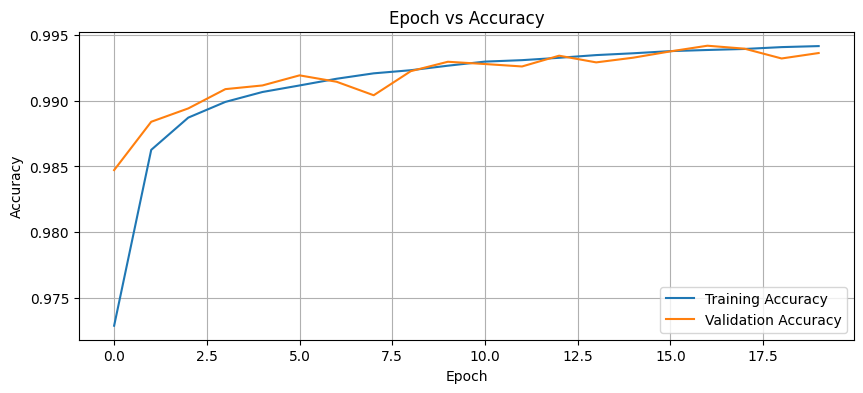

In [ ]:
# Plot 1: Epoch vs Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Epoch vs Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Downsampling

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.6586 - loss: 0.7132 - val_accuracy: 0.5366 - val_loss: 0.7169
Epoch 2/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.6933 - loss: 0.6347 - val_accuracy: 0.6774 - val_loss: 0.6501
Epoch 3/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.6952 - loss: 0.6389 - val_accuracy: 0.5581 - val_loss: 0.6645
Epoch 4/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.6905 - loss: 0.6346 - val_accuracy: 0.5915 - val_loss: 0.7611
Epoch 5/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.6942 - loss: 0.6304 - val_accuracy: 0.6353 - val_loss: 0.5854
Epoch 6/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.6834 - loss: 0.6430 - val_accuracy: 0.6607 - val_loss: 0.5610
Epoch 7/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.7000 - loss: 0.6171 - val_accuracy: 0.5735 - val_loss: 0.7056
Epoch 8/20
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.6933 -

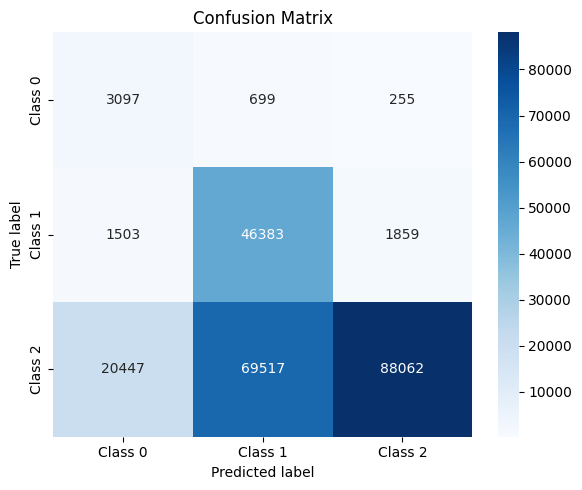

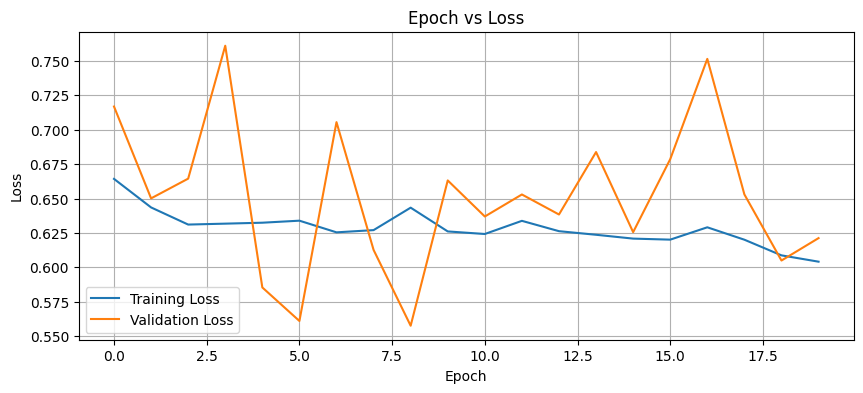

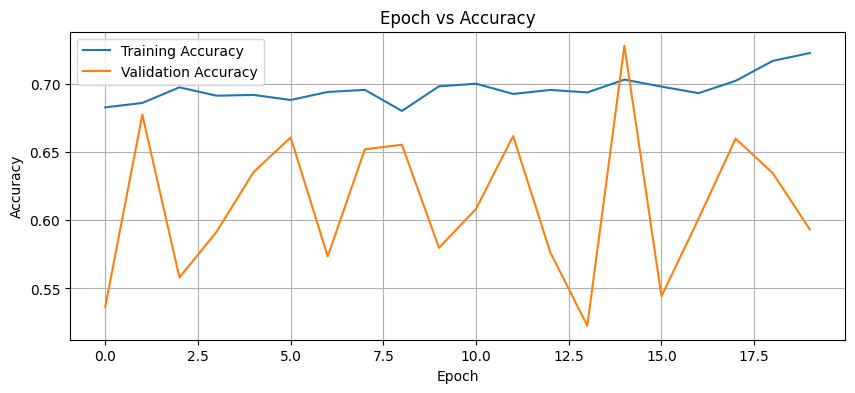

In [ ]:
# X: ensure float32
X_train_lstm = np.asarray(X_train_downsampled, dtype=np.float32).reshape(X_train_downsampled.shape[0], 1, X_train_downsampled.shape[1])
X_test_lstm  = np.asarray(X_test,  dtype=np.float32).reshape(X_test.shape[0],  1, X_test.shape[1])

# y: integers 0..2 for both train and val
y_train_int = np.asarray(y_train_downsampled, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

model = models.Sequential([
    layers.LSTM(128, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_lstm, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_int),
    verbose=1
)

# model: trained Keras model
# X_test_lstm: shape (n_samples, timesteps, n_features)
# y_test_int: integer labels in {0,1,2}

# 1) Evaluate on sparse (integer) labels
loss, acc = model.evaluate(X_test_lstm, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# 2) Predict class probabilities and convert to class indices
y_pred_probs = model.predict(X_test_lstm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3) Ground truth (already integers)
y_true = y_test_int

# 4) Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, digits=4))

# Optional: customize class names if you have them; otherwise generic:
class_names = [f"Class {i}" for i in range(3)]

# 5) Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Assuming `history` is the History object returned by model.fit()

# Plot 1: Epoch vs Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Epoch vs Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Oversampling

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 323s 5ms/step - accuracy: 0.6932 - loss: 0.6332 - val_accuracy: 0.7385 - val_loss: 0.6337
Epoch 2/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 319s 5ms/step - accuracy: 0.7247 - loss: 0.5924 - val_accuracy: 0.5474 - val_loss: 0.6528
Epoch 3/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 320s 5ms/step - accuracy: 0.6946 - loss: 0.6296 - val_accuracy: 0.6606 - val_loss: 0.6354
Epoch 4/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 333s 5ms/step - accuracy: 0.7231 - loss: 0.6099 - val_accuracy: 0.6157 - val_loss: 0.6676
Epoch 5/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 381s 5ms/step - accuracy: 0.7112 - loss: 0.6313 - val_accuracy: 0.6788 - val_loss: 0.6342
Epoch 6/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 321s 5ms/step - accuracy: 0.7291 - loss: 0.6032 - val_accuracy: 0.6941 - val_loss: 0.6281
Epoch 7/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 320s 5ms/step - accuracy: 0.7220 - loss: 0.6171 - val_accuracy: 0.5270 - val_loss: 0.6395
Epoch 8/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 321s 5ms/step - ac

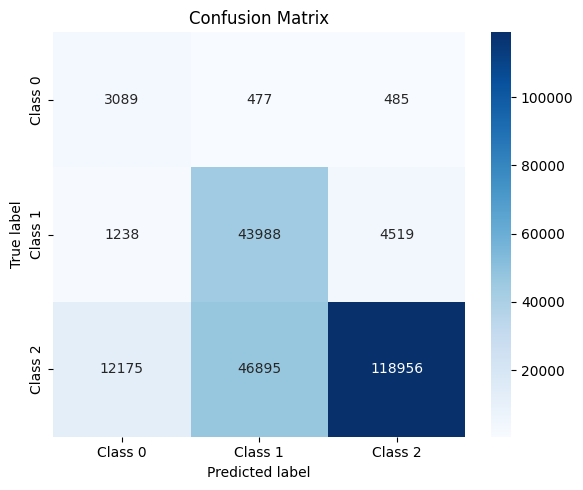

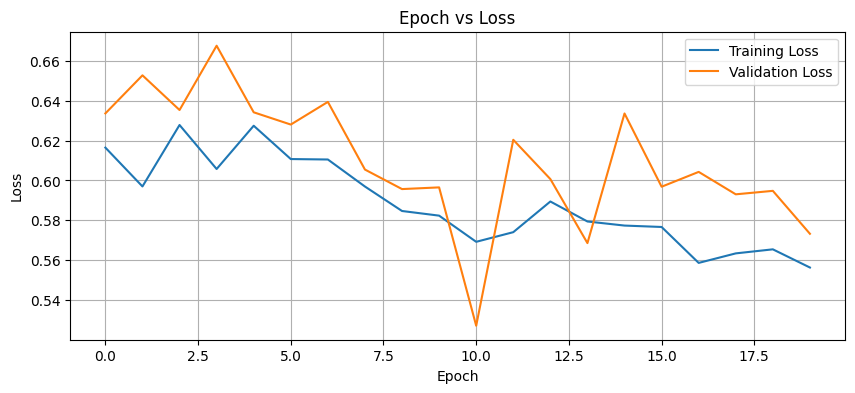

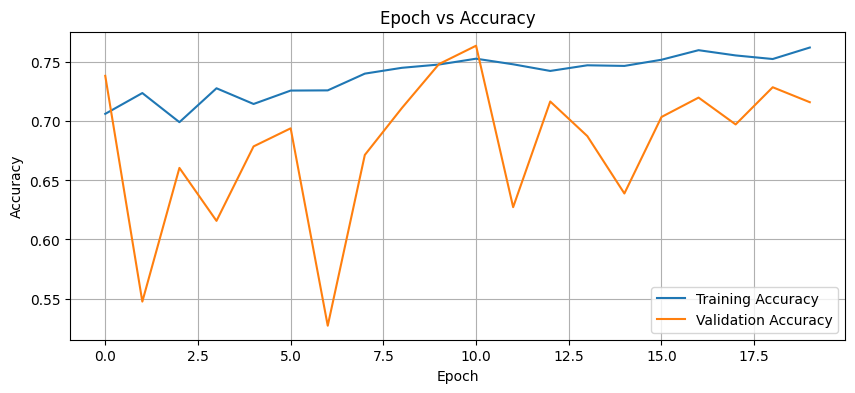

In [ ]:
# X: ensure float32
X_train_lstm = np.asarray(X_train_oversampled, dtype=np.float32).reshape(X_train_oversampled.shape[0], 1, X_train_oversampled.shape[1])
X_test_lstm  = np.asarray(X_test,  dtype=np.float32).reshape(X_test.shape[0],  1, X_test.shape[1])

# y: integers 0..2 for both train and val
y_train_int = np.asarray(y_train_oversampled, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

model = models.Sequential([
    layers.LSTM(128, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_lstm, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_int),
    verbose=1
)


# model: trained Keras model
# X_test_lstm: shape (n_samples, timesteps, n_features)
# y_test_int: integer labels in {0,1,2}

# 1) Evaluate on sparse (integer) labels
loss, acc = model.evaluate(X_test_lstm, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# 2) Predict class probabilities and convert to class indices
y_pred_probs = model.predict(X_test_lstm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3) Ground truth (already integers)
y_true = y_test_int

# 4) Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, digits=4))

# Optional: customize class names if you have them; otherwise generic:
class_names = [f"Class {i}" for i in range(3)]

# 5) Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Assuming `history` is the History object returned by model.fit()

# Plot 1: Epoch vs Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Epoch vs Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 323s 5ms/step - accuracy: 0.6932 - loss: 0.6332 - val_accuracy: 0.7385 - val_loss: 0.6337
Epoch 2/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 319s 5ms/step - accuracy: 0.7247 - loss: 0.5924 - val_accuracy: 0.5474 - val_loss: 0.6528
Epoch 3/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 320s 5ms/step - accuracy: 0.6946 - loss: 0.6296 - val_accuracy: 0.6606 - val_loss: 0.6354
Epoch 4/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 333s 5ms/step - accuracy: 0.7231 - loss: 0.6099 - val_accuracy: 0.6157 - val_loss: 0.6676
Epoch 5/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 381s 5ms/step - accuracy: 0.7112 - loss: 0.6313 - val_accuracy: 0.6788 - val_loss: 0.6342
Epoch 6/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 321s 5ms/step - accuracy: 0.7291 - loss: 0.6032 - val_accuracy: 0.6941 - val_loss: 0.6281
Epoch 7/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 320s 5ms/step - accuracy: 0.7220 - loss: 0.6171 - val_accuracy: 0.5270 - val_loss: 0.6395
Epoch 8/20
66730/66730 ━━━━━━━━━━━━━━━━━━━━ 321s 5ms/step - ac

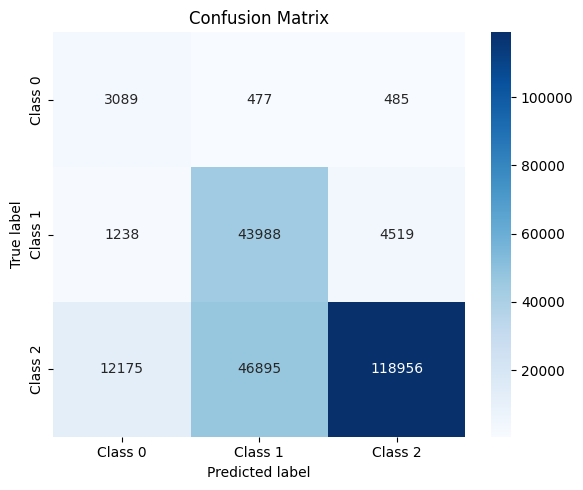

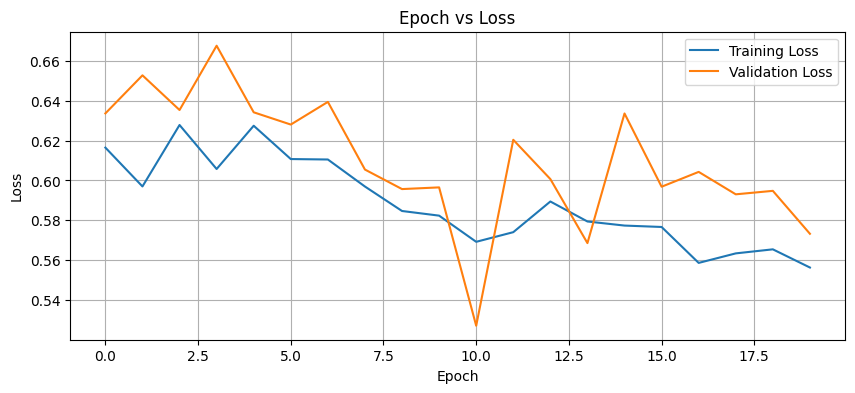

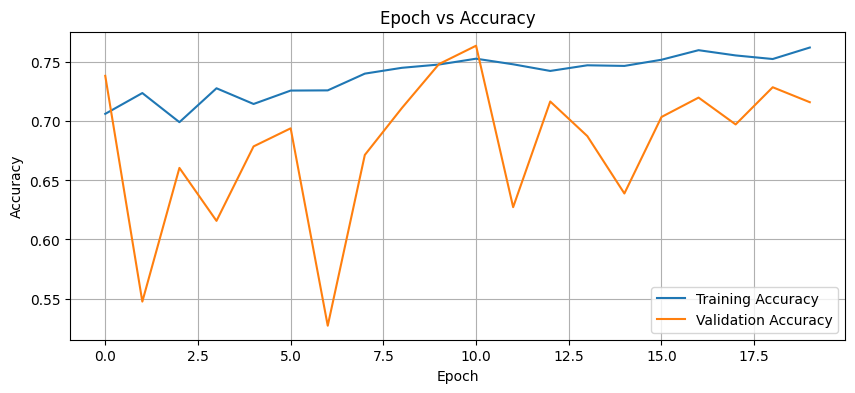

In [ ]:
# X: ensure float32
X_train_lstm = np.asarray(X_train_oversampled, dtype=np.float32).reshape(X_train_oversampled.shape[0], 1, X_train_oversampled.shape[1])
X_test_lstm  = np.asarray(X_test,  dtype=np.float32).reshape(X_test.shape[0],  1, X_test.shape[1])

# y: integers 0..2 for both train and val
y_train_int = np.asarray(y_train_oversampled, dtype=np.int32)
y_test_int  = np.asarray(y_test,  dtype=np.int32)

model = models.Sequential([
    layers.LSTM(128, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_lstm, y_train_int,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_int),
    verbose=1
)

# --- Assumptions from training step ---
# model: trained Keras model
# X_test_lstm: shape (n_samples, timesteps, n_features)
# y_test_int: integer labels in {0,1,2}

# 1) Evaluate on sparse (integer) labels
loss, acc = model.evaluate(X_test_lstm, y_test_int, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

# 2) Predict class probabilities and convert to class indices
y_pred_probs = model.predict(X_test_lstm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3) Ground truth (already integers)
y_true = y_test_int

# 4) Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, digits=4))

# Optional: customize class names if you have them; otherwise generic:
class_names = [f"Class {i}" for i in range(3)]

# 5) Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Assuming `history` is the History object returned by model.fit()

# Plot 1: Epoch vs Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Epoch vs Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Anomaly Detection - hybrid approach + GUI

In [ ]:
X_train.head(1)

,Duration,ResponseTimeTimeMedian,FlowBytesReceived,PacketLengthSkewFromMedian,FlowBytesSent,ResponseTimeTimeStandardDeviation,PacketTimeMode,PacketLengthMode,ResponseTimeTimeSkewFromMedian,PacketTimeSkewFromMode,...,PacketTimeMean,PacketLengthSkewFromMode,PacketLengthVariance,ResponseTimeTimeCoefficientofVariation,ResponseTimeTimeSkewFromMode,FlowSentRate,PacketLengthMean,ResponseTimeTimeMode,PacketTimeSkewFromMedian,PacketTimeVariance
971327,0.015196,0.015196,66,0.0,55,0.0,0.0,55,-10.0,1.0,...,0.007598,1.0,30.25,0.0,-10.0,3619.373519,60.5,0.015196,0.0,0.000058


In [ ]:
# Isolation Forest on training data
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train)

X_train_aug = X_train.copy()
X_test_aug  = X_test.copy()

X_train_aug['iso_score'] = iso.decision_function(X_train_aug)
X_test_aug['iso_score'] = iso.decision_function(X_test_aug)

# Save list of feature columns (order is critical!)
feature_list = list(X_train_aug.columns)
joblib.dump(feature_list, "/content/drive/MyDrive/Dataset/Model/features.pkl")

# Random Forest classifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_aug, y_train)

y_pred = clf.predict(X_test_aug)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4051
           1       1.00      1.00      1.00     49745
           2       1.00      1.00      1.00    178026

    accuracy                           1.00    231822
   macro avg       0.98      0.96      0.97    231822
weighted avg       1.00      1.00      1.00    231822

[[  3607      1    443]
 [     0  49726     19]
 [   278      0 177748]]


              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4051
           1       1.00      1.00      1.00     49745
           2       1.00      1.00      1.00    178026

    accuracy                           1.00    231822
   macro avg       0.98      0.96      0.97    231822
weighted avg       1.00      1.00      1.00    231822



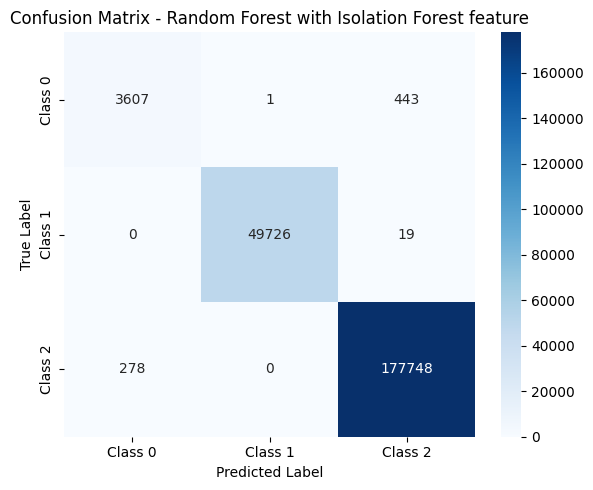

In [ ]:
# Get model predictions
y_pred = clf.predict(X_test_aug)
y_true = y_test

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(len(set(y_true)))],
            yticklabels=[f"Class {i}" for i in range(len(set(y_true)))])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest with Isolation Forest feature")
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(iso, "/content/drive/MyDrive/Dataset/Model/isolation_forest.pkl")
joblib.dump(clf, "/content/drive/MyDrive/Dataset/Model/rf_classifier.pkl")

['/content/drive/MyDrive/Dataset/Model/rf_classifier.pkl']

In [ ]:
# Load trained models
iso = joblib.load("/content/drive/MyDrive/Dataset/Model/isolation_forest.pkl")
clf = joblib.load("/content/drive/MyDrive/Dataset/Model/rf_classifier.pkl")

# Define labels mapping
label_map = {0: "Benign", 1: "Malicious", 2: "NonDoH"}

train_features = ['PacketLengthSkewFromMode', 'FlowSentRate', 'PacketTimeVariance',
       'ResponseTimeTimeStandardDeviation', 'FlowBytesReceived',
       'ResponseTimeTimeCoefficientofVariation', 'PacketLengthMode',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketLengthVariance',
       'ResponseTimeTimeMedian', 'PacketLengthCoefficientofVariation',
       'PacketTimeMean', 'PacketTimeSkewFromMedian',
       'PacketTimeCoefficientofVariation', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode', 'PacketLengthMedian',
       'PacketTimeSkewFromMode', 'PacketLengthMean', 'ResponseTimeTimeMean',
       'FlowBytesSent', 'Duration', 'PacketLengthSkewFromMedian',
       'PacketTimeStandardDeviation', 'ResponseTimeTimeVariance',
       'ResponseTimeTimeMode', 'FlowReceivedRate',
       'PacketLengthStandardDeviation']
# Function to handle uploaded CSV
def predict_csv(file_path):
    # Read CSV
    X_new = pd.read_csv(file_path)
    X_new = X_new[train_features]
    # Add iso_score from Isolation Forest
    X_new["iso_score"] = iso.decision_function(X_new)

    # Predict
    preds = clf.predict(X_new)
    preds = [label_map[p] for p in preds]

    # Return as dataframe for nice output
    result = pd.DataFrame({"Prediction": preds})
    print(X_new)
    print(result)
    return result

# Gradio UI
iface = gr.Interface(
    fn=predict_csv,
    inputs=gr.File(type="filepath", file_types=[".csv"]),
    outputs=gr.Dataframe(),
    title="Hybrid Anomaly Detection + Classification",
    description="Upload X_test.csv to get predictions (NonDoH, Benign, Malicious)."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0e462e68a55ed94d0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
X_train_aug

,Duration,ResponseTimeTimeMedian,FlowBytesReceived,PacketLengthSkewFromMedian,FlowBytesSent,ResponseTimeTimeStandardDeviation,PacketTimeMode,PacketLengthMode,ResponseTimeTimeSkewFromMedian,PacketTimeSkewFromMode,...,PacketLengthSkewFromMode,PacketLengthVariance,ResponseTimeTimeCoefficientofVariation,ResponseTimeTimeSkewFromMode,FlowSentRate,PacketLengthMean,ResponseTimeTimeMode,PacketTimeSkewFromMedian,PacketTimeVariance,iso_score
971327,0.015196,0.015196,66,0.000000,55,0.000000,0.000000,55,-10.000000,1.000000,...,1.000000,30.250000,0.000000,-10.000000,3619.373519,60.500000,0.015196,0.000000,0.000058,0.182241
70120,0.877027,0.002404,16556,1.385532,2124,0.021648,0.000000,54,2.011162,0.770564,...,0.525467,949623.996327,1.279692,0.779960,2421.818256,566.060606,0.000032,1.381723,0.095988,0.146017
427647,30.750052,0.028078,6437,1.215966,1724,0.011169,0.000000,66,-1.655194,0.643364,...,0.405322,633548.616780,0.509649,1.960164,56.064946,388.619048,0.000022,1.912895,130.980798,0.158337
639013,61.271434,0.000925,61631,2.386242,4195,0.011545,0.112628,1484,1.684470,0.465096,...,-1.276868,450564.249796,1.558578,0.496614,68.465837,626.914286,0.001674,1.391959,198.808865,0.022342
1037129,0.118125,0.028188,848,1.261011,2431,0.001434,0.000000,54,1.609636,1.867555,...,0.453391,131799.573333,0.049510,0.656863,20579.894180,218.600000,0.028016,0.985514,0.001388,0.132588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111053,0.083422,0.083422,66,0.000000,55,0.000000,0.000000,55,-10.000000,1.000000,...,1.000000,30.250000,0.000000,-10.000000,659.298506,60.500000,0.083422,0.000000,0.001740,0.171500
261010,25.551587,0.024730,8356,1.041878,4014,0.013266,0.000000,66,-1.751192,0.881315,...,0.449064,92783.938189,0.780997,1.278380,157.093961,202.786885,0.000027,2.538596,136.869194,0.158142
132874,0.020603,0.020603,66,0.000000,55,0.000000,0.000000,55,-10.000000,1.000000,...,1.000000,30.250000,0.000000,-10.000000,2669.514148,60.500000,0.020603,0.000000,0.000106,0.184491
675898,0.015130,0.015130,66,0.000000,55,0.000000,0.000000,55,-10.000000,1.000000,...,1.000000,30.250000,0.000000,-10.000000,3635.161930,60.500000,0.015130,0.000000,0.000057,0.182241


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://995e386a3bfa7de01f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
X_test.head(1).to_csv('/content/drive/MyDrive/Dataset/Model/X_test_one_row_.csv', index=False, columns=X_train.columns)

In [ ]:
X_test.head(1)

,Duration,ResponseTimeTimeMedian,FlowBytesReceived,PacketLengthSkewFromMedian,FlowBytesSent,ResponseTimeTimeStandardDeviation,PacketTimeMode,PacketLengthMode,ResponseTimeTimeSkewFromMedian,PacketTimeSkewFromMode,...,PacketTimeMean,PacketLengthSkewFromMode,PacketLengthVariance,ResponseTimeTimeCoefficientofVariation,ResponseTimeTimeSkewFromMode,FlowSentRate,PacketLengthMean,ResponseTimeTimeMode,PacketTimeSkewFromMedian,PacketTimeVariance
916299,0.02676,0.02676,60,0.0,55,0.0,0.0,55,-10.0,1.0,...,0.01338,1.0,6.25,0.0,-10.0,2055.306428,57.5,0.02676,0.0,0.000179


In [ ]:
print("RF expects:", feature_list)
print("Uploaded has:", list(pd.read_csv('/content/drive/MyDrive/Dataset/Model/X_test_one_row_.csv').columns))


RF expects: ['Duration', 'ResponseTimeTimeMedian', 'FlowBytesReceived', 'PacketLengthSkewFromMedian', 'FlowBytesSent', 'ResponseTimeTimeStandardDeviation', 'PacketTimeMode', 'PacketLengthMode', 'ResponseTimeTimeSkewFromMedian', 'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation', 'FlowReceivedRate', 'PacketLengthCoefficientofVariation', 'PacketTimeMedian', 'PacketTimeStandardDeviation', 'PacketLengthMedian', 'PacketLengthStandardDeviation', 'ResponseTimeTimeVariance', 'ResponseTimeTimeMean', 'PacketTimeMean', 'PacketLengthSkewFromMode', 'PacketLengthVariance', 'ResponseTimeTimeCoefficientofVariation', 'ResponseTimeTimeSkewFromMode', 'FlowSentRate', 'PacketLengthMean', 'ResponseTimeTimeMode', 'PacketTimeSkewFromMedian', 'PacketTimeVariance', 'iso_score']
Uploaded has: ['Duration', 'ResponseTimeTimeMedian', 'FlowBytesReceived', 'PacketLengthSkewFromMedian', 'FlowBytesSent', 'ResponseTimeTimeStandardDeviation', 'PacketTimeMode', 'PacketLengthMode', 'ResponseTimeTimeSkewFromMedian